# **2. Deep Learning for NLP**
**Fake news classifier:** Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model


* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice.
* Upload the the model to the Hugging Face Hub, and add a link to your model below.

Answer the following question: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

**Write up:**
* Link to the model on Hugging Face Hub: https://huggingface.co/bopoku/Fake-news-detection/commit/a3cb9601853d504f4a507a006a71fbc9d28f2d2e
[link text](https://)
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)




On all datasets, random forest outperformed the others in terms of accuracy. However, the accuracy score alone is not a good measure of a model's performance; thus, we also evaluate the performance of learning models using recall, precision, and the F1-score. I deployed Linear SVC, to improve this model, one has to chose a soft margin rather than a hard margin, which means intentionally let some data points enter the margin so that the classifier does not overfit on the training sample. And its performance also performed so well.

In [ ]:
#Here we make the necessary imports for this project.
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC, LinearSVC
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
from sklearn import metrics
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy.cli
from sklearn.ensemble import RandomForestClassifier

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
spacy.cli.download("en_core_web_lg")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


Now, let's read the data into a DataFrame and get the data's first five records.

In [ ]:
#Reading the input file
df_fake = pd.read_csv("/content/Fake.csv")

In [ ]:
# Load the real_news data
df_true = pd.read_csv("/content/True.csv")


In [ ]:
#Get fake news data head
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#Get true news data head
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#subjects of True news. The subject unique() method is used to determine all types of unique values in the Team column.
df_fake.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [ ]:
#subjects of True news. The subject unique() method is used to determine all types of unique values in the Team column.
df_true.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Data cleaning and preparation. The dataset includes a label column with the data type Text Category. The label column in the dataset is divided into two sections labeled "Fake" and "Real." To train the model, the label column must be converted to a numerical one. 

In [ ]:
#Add a categorical target to the data to label fake news as 1 and true news as 0.
df_fake['is_fake']=np.ones(df_fake.shape[0])
df_true['is_fake']=np.zeros(df_true.shape[0])

In [ ]:
#To create a news dataframe, concatenate fake news and true news along the index axis.
real_news = pd.concat([df_fake, df_true], axis=0)

In [ ]:
#By passing the frac parameter to sample(), you can shuffle the DataFrame and get the data head
real_news = real_news.sample(frac=1)
real_news.head()

,title,text,subject,date,is_fake
22675,Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...,Episode #120 of SUNDAY WIRE SHOW finally resum...,US_News,"January 31, 2016",1.0
20086,EXTORTION? HOW IRAN Used Nuke Deal To Force Ob...,If I were a European and was forced to deal wi...,left-news,"Aug 23, 2016",1.0
15700,MEGYN KELLY RIPS INTO OBAMA ON HIS SWIPE OF FO...,,politics,"May 14, 2015",1.0
7842,Judge gives Florida voters more time to regist...,(Reuters) - Florida residents were given six e...,politicsNews,"October 12, 2016",0.0
6631,Trump wins Electoral College vote; a few elect...,"SEATTLE/AUSTIN, Texas (Reuters) - Republican D...",politicsNews,"December 19, 2016",0.0


We perform basic data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'News')

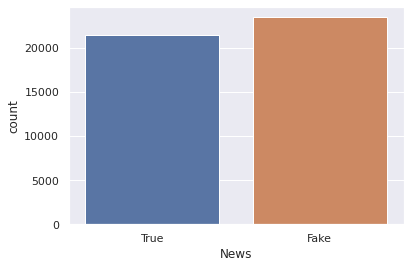

In [ ]:
#Distribution of classes in target
sns.set_theme(style="darkgrid")
class_target = sns.countplot(real_news.is_fake)
class_target.set_xticklabels(['True','Fake'])
class_target.set_xlabel('News')

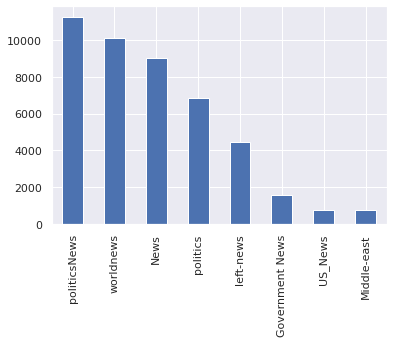

In [ ]:
# Distribution of subject of news
real_news['subject'].value_counts().plot(kind = "bar")

Modeling and deparing the data

In [ ]:
# Preprocess the text with function processtext()
stop_w = set(stopwords.words('english'))
punct = list(string.punctuation)
lemmz = WordNetLemmatizer()

def refinetext(text):
    text=re.sub("[^a-zA-Z]"," ",text) 
    text=text.lower() 
    tokens=word_tokenize(text) 
    
    tokens=[token for token in tokens if token not in stop_w and token not in punct] 
    tokens=[lemmz.lemmatize(token) for token in tokens]
    text=" ".join(tokens)
    return text
real_news["refinetext"] = real_news.text.apply(lambda x: refinetext(x))

In [ ]:
load_spacy = spacy.load('en_core_web_lg')

with load_spacy.disable_pipes():
    vectors = np.array([load_spacy(text).vector for text in real_news["refinetext"]])

In [ ]:
x = vectors
y = real_news['is_fake'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30, random_state=42)

In [ ]:
def performance(model, X_train, y_train ,X_test ,y_test, y_pred, model_name):
 
    datafram=pd.DataFrame({'Train_accuracy':model.score(X_train,y_train),"Test_accuracy":model.score(X_test,y_test),
                       "Precision":precision_score(y_pred,y_test),"Recall":recall_score(y_pred,y_test),
                       "F1_Score":f1_score(y_pred,y_test)}, index=[model_name])
    return datafram

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(f'train acc: {rfc.score(X_train, y_train)*100:.2f}%')
print(f'test precision: {precision_score(y_pred,y_test):.2f}')
print(f'test acc: {rfc.score(X_test, y_test)*100:.2f}%')
print(f'test f1_score: {f1_score(y_pred,y_test):.2f}')
print(f'test recall: {recall_score(y_pred,y_test):.2f}')

train acc: 100.00%
test precision: 0.95
test acc: 94.65%
test f1_score: 0.95
test recall: 0.95


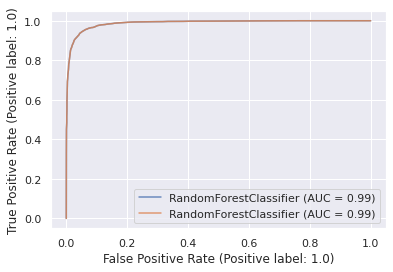

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [ ]:
rfc_score = performance(rfc, X_train, y_train ,X_test ,y_test, y_pred, "Random Forest")
rfc_score

,Train_accuracy,Test_accuracy,Precision,Recall,F1_Score
Random Forest,0.999968,0.946548,0.947863,0.949486,0.948674


In [ ]:
X = real_news["refinetext"]
tfidf = TfidfVectorizer(max_features=5000)
X = (tfidf.fit_transform(X)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=1)

In [ ]:
LSVC = LinearSVC(random_state=42)
LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)

print(f'train accu: {LSVC.score(X_train, y_train)*100:.2f}%')
print(f'test precision: {precision_score(y_pred,y_test):.2f}')
print(f'test accu: {LSVC.score(X_test, y_test)*100:.2f}%')
print(f'test f1_score: {f1_score(y_pred,y_test):.2f}')
print(f'test recall: {recall_score(y_pred,y_test):.2f}')


train accu: 99.89%
test precision: 0.99
test accu: 99.26%
test f1_score: 0.99
test recall: 0.99


In [ ]:
LSVC_score = performance(LSVC, X_train, y_train ,X_test ,y_test, y_pred, "LinearSVC")
LSVC_score

,Train_accuracy,Test_accuracy,Precision,Recall,F1_Score
LinearSVC,0.998936,0.992576,0.992673,0.993183,0.992928


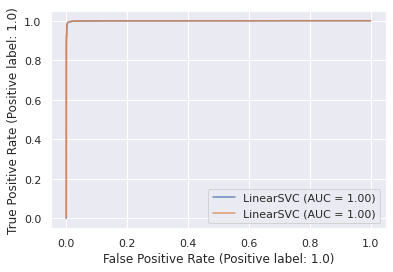

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(LSVC, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()